# Applying MCMC on CO2 data

We take again the CO2 problem, and now try to do better with EMCEE...

In [2]:
%matplotlib inline
import matplotlib
from matplotlib import pyplot as plt
from matplotlib.ticker import MaxNLocator
from mpl_toolkits.mplot3d import Axes3D
import matplotlib.tri as tri

import numpy as np
import pandas as pd
import scipy, emcee, corner

# We fix the random seed to always get the same problem

np.random.seed(seed=42)

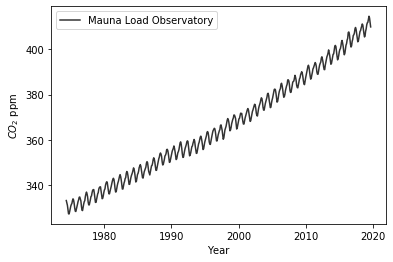

In [4]:
import pandas as pd # we need the pandas library, really useful to read excel, csv files, etc...
dat = pd.read_table('CO2_noaa_01102019.csv',
                  comment='#', sep='\s+', header=None, na_values=[-1, -99.99])

# what are the columns? 
dat.columns = ['year', 'month', 'dec_year', 'co2_av', 'co2_interp', 'co2_trend', 'days']

# let's make sure there is no NAN (missign values, happens in various geochemical records!)
dat.dropna(inplace=True)  # necessary because optimisation fails if there are NaNs in the data

# let's plot those data
plt.plot(dat.loc[:, 'dec_year'], dat.loc[:, 'co2_av'], c=(0,0,0,0.8), label='Mauna Load Observatory')

plt.xlabel('Year')
plt.ylabel('$CO_2$ ppm')

plt.legend()

# Notre modèle

In [6]:
def model_direct(time, p0, p1, p2, p3, phase, amp):
    seasonal = np.sin((time - phase) * (2 * np.pi)) * amp
    return time**3 * p3 + time**2 * p2 + time * p1 + p0 + seasonal

# Rappel du fit de la dernière fois

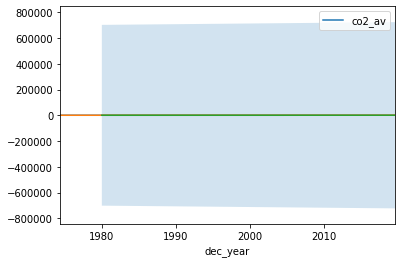

In [9]:
p, cov = scipy.optimize.curve_fit(model_direct, dat.loc[:, 'dec_year'], dat.loc[:, 'co2_av'])

ax = dat.plot('dec_year', 'co2_av')

ax.plot(dat.loc[:, 'dec_year'], model_direct(dat.loc[:, 'dec_year'], *p))

# loading the library
from uncertainties import unumpy as un

# we define an uncertainties array of the parameters 
# and their variance/covariance (see uncertainties documentation)
params = un.uarray(p, np.sqrt(np.diag(cov)))

# we redefine our function to work with unumpy
def co2_record_unumpy(time, p0, p1, p2, p3, phase, amp):
    seasonal = un.sin((time - phase) * (2 * np.pi)) * amp
    return time**3 * p3 + time**2 * p2 + time * p1 + p0 + seasonal

# new time step
time = np.arange(1980, 2100, 0.1)
pred = co2_record_unumpy(time, *params)

plt.plot(time, un.nominal_values(pred))

plt.fill_between(time, un.nominal_values(pred) - un.std_devs(pred),
                 un.nominal_values(pred) + un.std_devs(pred), alpha=0.2, zorder=-1)